#### We will try to make a **comparison** between building and training a **nerual network** and using **Transfer learning(pretrained model)**, in terms of **trainig time, ease of creation, accuracy and consistancy**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow==V2.9.1

## Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
import cv2
import os
from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
warnings.filterwarnings('ignore')
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 KB 31.8 MB/s eta 0:00:00


In [ ]:
# import tensorflow as tf
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# for gpu in physical_devices:
#     tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# generating dataset from directory

# Generating train dataset
data = tf.keras.utils.image_dataset_from_directory(directory = '/content/drive/MyDrive/Colab Notebooks/dataset',
                                                   color_mode = 'rgb',
                                                   batch_size = 64,
                                                   image_size = (224,224),
                                                   shuffle=True,
                                                   seed = 2022)


Found 3002 files belonging to 4 classes.


## Displaying data distribution

In [ ]:
labels = np.concatenate([y for x,y in data], axis=0)

In [ ]:
values = pd.value_counts(labels)
values = values.sort_index()

In [ ]:
values

0    735
1    816
2    503
3    948
dtype: int64

### Checking labels

In [ ]:
# getting class names
class_names = data.class_names
for idx, name in enumerate(class_names):
  print(f"{idx} = {name}", end=", ")

0 = cataract, 1 = diabetic_retinopathy, 2 = glaucoma, 3 = normal, 

### The data is well distributed among the classes and is balanced

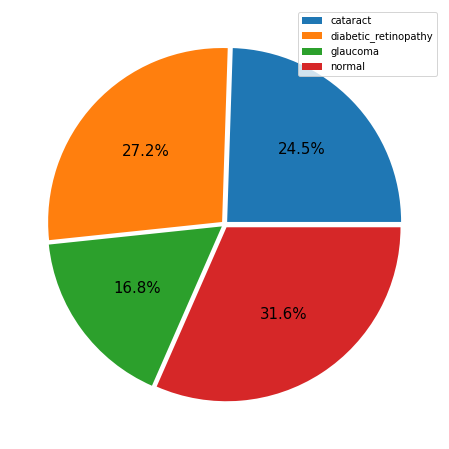

In [ ]:
plt.figure(figsize=(12,8))
plt.pie(values,autopct='%1.1f%%', explode = [0.02,0.02,0.02, 0.02], textprops = {"fontsize":15})
plt.legend(labels=data.class_names)
plt.show()

## Getting a data generator to explore the data

In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

### Each batch contains 64 images, each image is 224x224

In [ ]:
batch[0].shape

(64, 224, 224, 3)

## Displaying some images

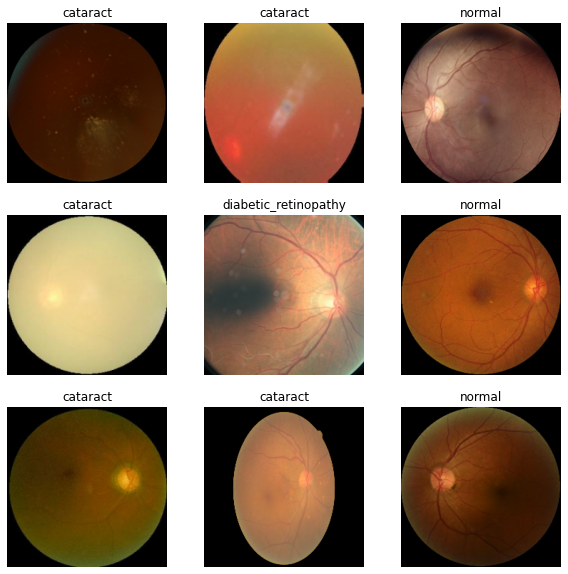

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Preprocessing images

## Standardize the data

In [ ]:
data = data.map(lambda x, y: (x/255, y))

In [ ]:
sample = data.as_numpy_iterator().next()

In [ ]:
print(sample[0].min())
print(sample[0].max())

0.0
1.0


## Spliting the data

In [ ]:
print("Total number of batchs = ",len(data))

Total number of batchs =  47


In [ ]:
train_size = int(0.7 * len(data)) +1
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))

In [ ]:
train = data.take(train_size)
remaining = data.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

In [ ]:
print(f"# train batchs = {len(train)}, # validate batchs = {len(val)}, # test batch = {len(test)}")
len(train) + len(val) + len(test)

# train batchs = 33, # validate batchs = 9, # test batch = 5


47

## Preparing test set

In [ ]:
test_iter = test.as_numpy_iterator()

In [ ]:
test_set = {"images":np.empty((0,224,224,3)), "labels":np.empty(0)}
while True:
    try:
        batch = test_iter.next()
        test_set['images'] = np.concatenate((test_set['images'], batch[0]))
        test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
    except:
        break

In [ ]:
y_true = test_set['labels']

# CNN from scratch

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

In [ ]:
# Displaying history loss/accuracy
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_his(history):
    plt.figure(figsize=(15,12))
    metrics = ['accuracy', 'loss']
    for i, metric in enumerate(metrics):
        plt.subplot(220+1+i)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
    plt.show()

In [ ]:
def create_baselineCNN():
    model = Sequential([
        Conv2D(filters = 64, kernel_size=3, activation = 'relu',padding='same', input_shape=(224,224,3)),
        Conv2D(filters = 64, kernel_size=3, activation = 'relu',padding='same'),
        BatchNormalization(),
        MaxPool2D(2),
        Dropout(0.3),

        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        BatchNormalization(),
        MaxPool2D(2),
        Dropout(0.3),
        
        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        BatchNormalization(),
        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        BatchNormalization(),
        MaxPool2D(2),
        Dropout(0.3),
        
        Flatten(),
        Dense(64, activation = 'relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(128, activation = 'relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(4, activation='softmax')
    ])
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model = create_baselineCNN()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     7

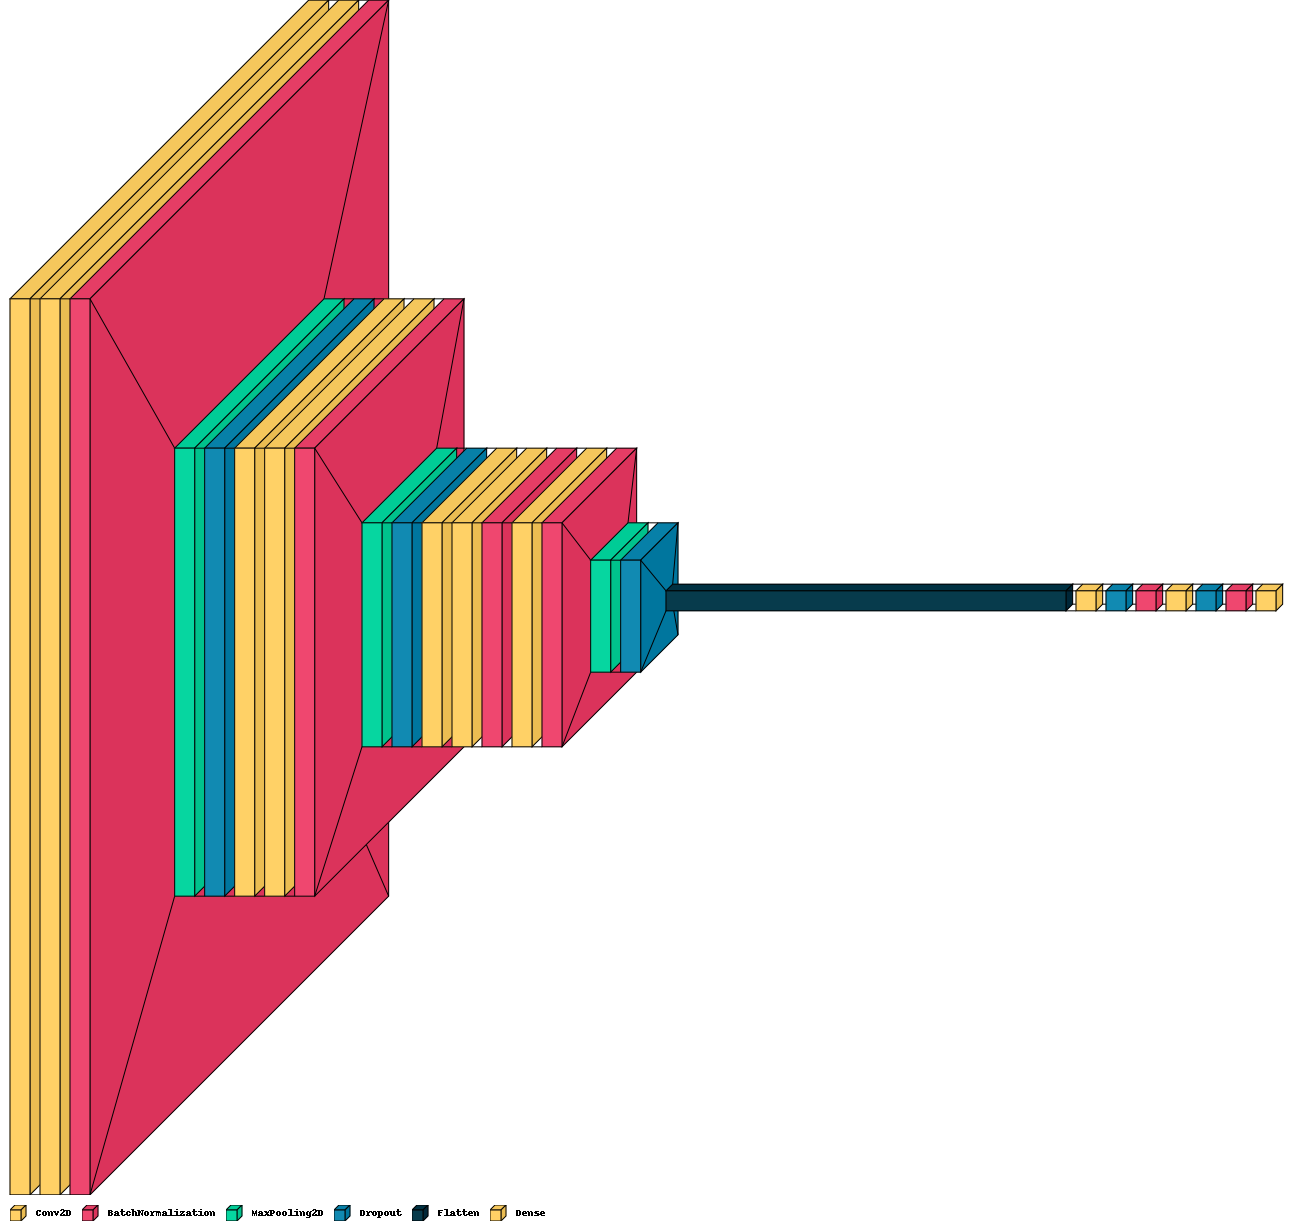

In [ ]:
model.summary()

visualkeras.layered_view(model,legend=True)

## Model training

In [ ]:
from keras import callbacks 
early_stop = callbacks.EarlyStopping(
        monitor="val_accuracy", 
        patience=20,
        verbose=1,
        mode="max",
        restore_best_weights=True, 
     )

history = model.fit(
    train,
    validation_data=val,
    epochs = 60,
    callbacks=[early_stop],
)

Epoch 1/60
33/33 [==============================] - 60s 1s/step - loss: 1.3387 - accuracy: 0.4730 - val_loss: 2.2632 - val_accuracy: 0.2899
Epoch 2/60
33/33 [==============================] - 43s 1s/step - loss: 0.9770 - accuracy: 0.5933 - val_loss: 5.5663 - val_accuracy: 0.2483
Epoch 3/60
33/33 [==============================] - 42s 1s/step - loss: 0.8146 - accuracy: 0.6681 - val_loss: 6.3550 - val_accuracy: 0.2795
Epoch 4/60
33/33 [==============================] - 42s 1s/step - loss: 0.7263 - accuracy: 0.7083 - val_loss: 8.0211 - val_accuracy: 0.2708
Epoch 5/60
33/33 [==============================] - 43s 1s/step - loss: 0.7080 - accuracy: 0.7188 - val_loss: 6.9486 - val_accuracy: 0.2622
Epoch 6/60
33/33 [==============================] - 43s 1s/step - loss: 0.6285 - accuracy: 0.7420 - val_loss: 9.0268 - val_accuracy: 0.2535
Epoch 7/60
33/33 [==============================] - 41s 1s/step - loss: 0.5657 - accuracy: 0.7718 - val_loss: 8.5741 - val_accuracy: 0.2726
Epoch 8/60
33/33 [==

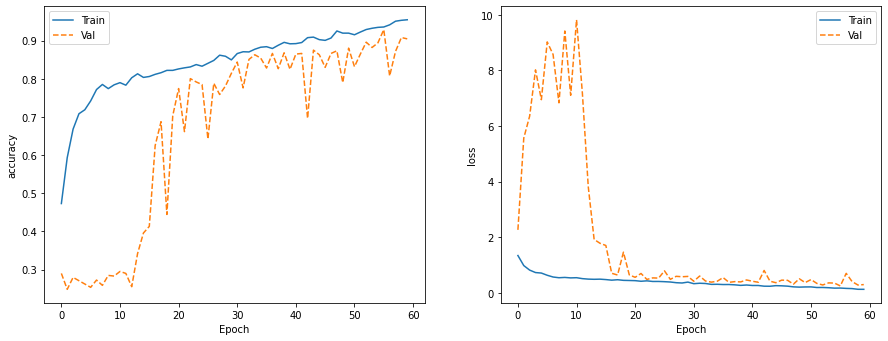

In [ ]:
plot_his(history)

## Evaluating the model on the test set

In [ ]:
y_pred = np.argmax(model.predict(test_set['images']), 1)

10/10 [==============================] - 4s 235ms/step


In [ ]:
print(classification_report(y_true, y_pred, target_names = class_names))

                      precision    recall  f1-score   support

            cataract       0.89      0.89      0.89        72
diabetic_retinopathy       1.00      0.99      1.00       102
            glaucoma       0.94      0.65      0.77        48
              normal       0.81      0.95      0.87        92

            accuracy                           0.90       314
           macro avg       0.91      0.87      0.88       314
        weighted avg       0.91      0.90      0.90       314



Text(0.5, 1.0, 'Confusion Matrix')

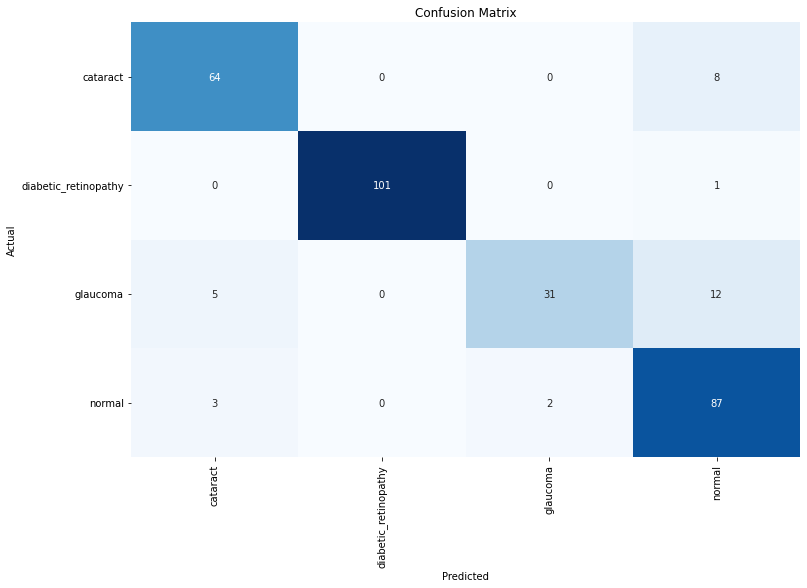

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(4)+.5, class_names, rotation=90)
plt.yticks(np.arange(4)+.5, class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Insights
#### The model acheived 90% accuracy
#### The training has run for 60 epochs and did not stop by early stopping
#### Although it achieved a good accuracy but validation loss wasn't consistant at all and has a lot of fluctuations

-----------
# Transfer Learning (Pretrained Model)
#### Here we will use a pretraind model and finetune it to fit our data
#### We are using EfficientNet pretrained model

In [ ]:
def make_model():
    effnet = EfficientNetB3(include_top=False, weights="imagenet",input_shape=(224,224,3), pooling='max') 
    effnet.trainable=False
    
    for layer in effnet.layers[83:]:
      layer.trainable=True
    
    x = effnet.output
    x = BatchNormalization()(x)
    x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x = Dropout(rate=.45, seed=2022)(x)        
    output=Dense(4, activation='softmax')(x)
    
    model= tf.keras.Model(inputs=effnet.input, outputs=output)
    model.compile(optimizer = 'adamax', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
    return model

In [ ]:
model = make_model()

43941136/43941136 [==============================] - 3s 0us/step


## Train the Model

In [ ]:
from keras import callbacks 

save_best_only = True #to save best model file
from keras.callbacks import ModelCheckpoint , EarlyStopping

mc = ModelCheckpoint(filepath='/content/drive/MyDrive/Project',                     
                     verbose=1,
                     save_best_only = True) 


early_stop = callbacks.EarlyStopping(
        monitor="val_accuracy", 
        patience=10,
        verbose=1,
        mode="max",
        restore_best_weights=True, 
     )

cb = [mc , early_stop]

history = model.fit(
    train,
    validation_data=val,
    epochs = 50,
    callbacks=[mc ,early_stop]
)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 19.8689 - accuracy: 0.5975
Epoch 1: val_loss improved from inf to 16.78011, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 116s 3s/step - loss: 19.8689 - accuracy: 0.5975 - val_loss: 16.7801 - val_accuracy: 0.3212
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 14.1839 - accuracy: 0.7325
Epoch 2: val_loss improved from 16.78011 to 12.91471, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 99s 3s/step - loss: 14.1839 - accuracy: 0.7325 - val_loss: 12.9147 - val_accuracy: 0.3733
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 10.9531 - accuracy: 0.7888
Epoch 3: val_loss improved from 12.91471 to 10.26542, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 97s 3s/step - loss: 10.9531 - accuracy: 0.7888 - val_loss: 10.2654 - val_accuracy: 0.3559
Epoch 4/50
33/33 [==============================] - ETA: 0s - loss: 8.6102 - accuracy: 0.8191
Epoch 4: val_loss improved from 10.26542 to 8.33025, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 97s 3s/step - loss: 8.6102 - accuracy: 0.8191 - val_loss: 8.3303 - val_accuracy: 0.2899
Epoch 5/50
33/33 [==============================] - ETA: 0s - loss: 6.8533 - accuracy: 0.8348
Epoch 5: val_loss improved from 8.33025 to 6.80091, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 99s 3s/step - loss: 6.8533 - accuracy: 0.8348 - val_loss: 6.8009 - val_accuracy: 0.4722
Epoch 6/50
33/33 [==============================] - ETA: 0s - loss: 5.4783 - accuracy: 0.8447
Epoch 6: val_loss improved from 6.80091 to 5.56315, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 99s 3s/step - loss: 5.4783 - accuracy: 0.8447 - val_loss: 5.5631 - val_accuracy: 0.4306
Epoch 7/50
33/33 [==============================] - ETA: 0s - loss: 4.4335 - accuracy: 0.8575
Epoch 7: val_loss improved from 5.56315 to 4.69452, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 100s 3s/step - loss: 4.4335 - accuracy: 0.8575 - val_loss: 4.6945 - val_accuracy: 0.4410
Epoch 8/50
33/33 [==============================] - ETA: 0s - loss: 3.5897 - accuracy: 0.8670
Epoch 8: val_loss improved from 4.69452 to 3.77788, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 99s 3s/step - loss: 3.5897 - accuracy: 0.8670 - val_loss: 3.7779 - val_accuracy: 0.5799
Epoch 9/50
33/33 [==============================] - ETA: 0s - loss: 2.9219 - accuracy: 0.8944
Epoch 9: val_loss improved from 3.77788 to 3.04790, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 99s 3s/step - loss: 2.9219 - accuracy: 0.8944 - val_loss: 3.0479 - val_accuracy: 0.6840
Epoch 10/50
33/33 [==============================] - ETA: 0s - loss: 2.4110 - accuracy: 0.8892
Epoch 10: val_loss improved from 3.04790 to 2.46389, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 99s 3s/step - loss: 2.4110 - accuracy: 0.8892 - val_loss: 2.4639 - val_accuracy: 0.7691
Epoch 11/50
33/33 [==============================] - ETA: 0s - loss: 1.9722 - accuracy: 0.9119
Epoch 11: val_loss improved from 2.46389 to 2.01877, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 100s 3s/step - loss: 1.9722 - accuracy: 0.9119 - val_loss: 2.0188 - val_accuracy: 0.8125
Epoch 12/50
33/33 [==============================] - ETA: 0s - loss: 1.6535 - accuracy: 0.9152
Epoch 12: val_loss improved from 2.01877 to 1.66868, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 101s 3s/step - loss: 1.6535 - accuracy: 0.9152 - val_loss: 1.6687 - val_accuracy: 0.8455
Epoch 13/50
33/33 [==============================] - ETA: 0s - loss: 1.4117 - accuracy: 0.9124
Epoch 13: val_loss improved from 1.66868 to 1.42867, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 99s 3s/step - loss: 1.4117 - accuracy: 0.9124 - val_loss: 1.4287 - val_accuracy: 0.8611
Epoch 14/50
33/33 [==============================] - ETA: 0s - loss: 1.1853 - accuracy: 0.9266
Epoch 14: val_loss improved from 1.42867 to 1.26503, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 100s 3s/step - loss: 1.1853 - accuracy: 0.9266 - val_loss: 1.2650 - val_accuracy: 0.8681
Epoch 15/50
33/33 [==============================] - ETA: 0s - loss: 1.0028 - accuracy: 0.9384
Epoch 15: val_loss improved from 1.26503 to 1.08315, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 98s 3s/step - loss: 1.0028 - accuracy: 0.9384 - val_loss: 1.0832 - val_accuracy: 0.8767
Epoch 16/50
33/33 [==============================] - ETA: 0s - loss: 0.9013 - accuracy: 0.9351
Epoch 16: val_loss improved from 1.08315 to 0.96437, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 100s 3s/step - loss: 0.9013 - accuracy: 0.9351 - val_loss: 0.9644 - val_accuracy: 0.8802
Epoch 17/50
33/33 [==============================] - ETA: 0s - loss: 0.7565 - accuracy: 0.9432
Epoch 17: val_loss improved from 0.96437 to 0.82297, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 101s 3s/step - loss: 0.7565 - accuracy: 0.9432 - val_loss: 0.8230 - val_accuracy: 0.9149
Epoch 18/50
33/33 [==============================] - ETA: 0s - loss: 0.7004 - accuracy: 0.9323
Epoch 18: val_loss improved from 0.82297 to 0.69770, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 100s 3s/step - loss: 0.7004 - accuracy: 0.9323 - val_loss: 0.6977 - val_accuracy: 0.9219
Epoch 19/50
33/33 [==============================] - ETA: 0s - loss: 0.5928 - accuracy: 0.9564
Epoch 19: val_loss did not improve from 0.69770
33/33 [==============================] - 43s 1s/step - loss: 0.5928 - accuracy: 0.9564 - val_loss: 0.7396 - val_accuracy: 0.8854
Epoch 20/50
33/33 [==============================] - ETA: 0s - loss: 0.5381 - accuracy: 0.9569
Epoch 20: val_loss did not improve from 0.69770
33/33 [==============================] - 42s 1s/step - loss: 0.5381 - accuracy: 0.9569 - val_loss: 0.7705 - val_accuracy: 0.8628
Epoch 21/50
33/33 [==============================] - ETA: 0s - loss: 0.4965 - accuracy: 0.9527
Epoch 21: val_loss improved from 0.69770 to 0.61358, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 102s 3s/step - loss: 0.4965 - accuracy: 0.9527 - val_loss: 0.6136 - val_accuracy: 0.9097
Epoch 22/50
33/33 [==============================] - ETA: 0s - loss: 0.4437 - accuracy: 0.9598
Epoch 22: val_loss improved from 0.61358 to 0.57130, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 101s 3s/step - loss: 0.4437 - accuracy: 0.9598 - val_loss: 0.5713 - val_accuracy: 0.9045
Epoch 23/50
33/33 [==============================] - ETA: 0s - loss: 0.4213 - accuracy: 0.9564
Epoch 23: val_loss improved from 0.57130 to 0.55622, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 104s 3s/step - loss: 0.4213 - accuracy: 0.9564 - val_loss: 0.5562 - val_accuracy: 0.9149
Epoch 24/50
33/33 [==============================] - ETA: 0s - loss: 0.3817 - accuracy: 0.9612
Epoch 24: val_loss improved from 0.55622 to 0.49451, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 102s 3s/step - loss: 0.3817 - accuracy: 0.9612 - val_loss: 0.4945 - val_accuracy: 0.9201
Epoch 25/50
33/33 [==============================] - ETA: 0s - loss: 0.3689 - accuracy: 0.9631
Epoch 25: val_loss did not improve from 0.49451
33/33 [==============================] - 43s 1s/step - loss: 0.3689 - accuracy: 0.9631 - val_loss: 0.5505 - val_accuracy: 0.8889
Epoch 26/50
33/33 [==============================] - ETA: 0s - loss: 0.3370 - accuracy: 0.9688
Epoch 26: val_loss improved from 0.49451 to 0.40213, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 103s 3s/step - loss: 0.3370 - accuracy: 0.9688 - val_loss: 0.4021 - val_accuracy: 0.9444
Epoch 27/50
33/33 [==============================] - ETA: 0s - loss: 0.3021 - accuracy: 0.9782
Epoch 27: val_loss improved from 0.40213 to 0.35571, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 103s 3s/step - loss: 0.3021 - accuracy: 0.9782 - val_loss: 0.3557 - val_accuracy: 0.9514
Epoch 28/50
33/33 [==============================] - ETA: 0s - loss: 0.3002 - accuracy: 0.9688
Epoch 28: val_loss did not improve from 0.35571
33/33 [==============================] - 44s 1s/step - loss: 0.3002 - accuracy: 0.9688 - val_loss: 0.4527 - val_accuracy: 0.9201
Epoch 29/50
33/33 [==============================] - ETA: 0s - loss: 0.3097 - accuracy: 0.9631
Epoch 29: val_loss did not improve from 0.35571
33/33 [==============================] - 43s 1s/step - loss: 0.3097 - accuracy: 0.9631 - val_loss: 0.3919 - val_accuracy: 0.9410
Epoch 30/50
33/33 [==============================] - ETA: 0s - loss: 0.3038 - accuracy: 0.9669
Epoch 30: val_loss did not improve from 0.35571
33/33 [==============================] - 42s 1s/step - loss: 0.3038 - accuracy: 0.9669 - val_loss: 0.3848 - val_accuracy: 0.9410
Epoch 31/50
33/33 [==============================] - E

33/33 [==============================] - 104s 3s/step - loss: 0.2488 - accuracy: 0.9744 - val_loss: 0.3438 - val_accuracy: 0.9410
Epoch 35/50
33/33 [==============================] - ETA: 0s - loss: 0.2549 - accuracy: 0.9735
Epoch 35: val_loss did not improve from 0.34382
33/33 [==============================] - 42s 1s/step - loss: 0.2549 - accuracy: 0.9735 - val_loss: 0.4049 - val_accuracy: 0.9271
Epoch 36/50
33/33 [==============================] - ETA: 0s - loss: 0.2347 - accuracy: 0.9763
Epoch 36: val_loss did not improve from 0.34382
33/33 [==============================] - 43s 1s/step - loss: 0.2347 - accuracy: 0.9763 - val_loss: 0.3517 - val_accuracy: 0.9427
Epoch 37/50
33/33 [==============================] - ETA: 0s - loss: 0.2349 - accuracy: 0.9759
Epoch 37: val_loss improved from 0.34382 to 0.27511, saving model to /content/drive/MyDrive/Project


33/33 [==============================] - 102s 3s/step - loss: 0.2349 - accuracy: 0.9759 - val_loss: 0.2751 - val_accuracy: 0.9601
Epoch 38/50
33/33 [==============================] - ETA: 0s - loss: 0.2310 - accuracy: 0.9744
Epoch 38: val_loss did not improve from 0.27511
33/33 [==============================] - 43s 1s/step - loss: 0.2310 - accuracy: 0.9744 - val_loss: 0.3160 - val_accuracy: 0.9479
Epoch 39/50
33/33 [==============================] - ETA: 0s - loss: 0.2272 - accuracy: 0.9806
Epoch 39: val_loss did not improve from 0.27511
33/33 [==============================] - 43s 1s/step - loss: 0.2272 - accuracy: 0.9806 - val_loss: 0.4345 - val_accuracy: 0.9288
Epoch 40/50
33/33 [==============================] - ETA: 0s - loss: 0.2320 - accuracy: 0.9740
Epoch 40: val_loss did not improve from 0.27511
33/33 [==============================] - 42s 1s/step - loss: 0.2320 - accuracy: 0.9740 - val_loss: 0.3793 - val_accuracy: 0.9306
Epoch 41/50
33/33 [==============================] - E

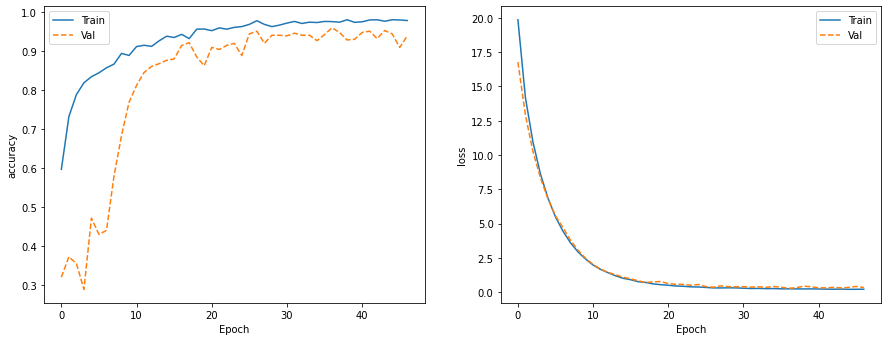

In [ ]:
plot_his(history)

## Evaluating the model on test set

In [ ]:
y_pred = np.argmax(model.predict(test_set['images']), 1)

10/10 [==============================] - 6s 189ms/step


In [ ]:
print(classification_report(y_true, y_pred, target_names = class_names))

                      precision    recall  f1-score   support

            cataract       0.97      0.97      0.97        72
diabetic_retinopathy       1.00      0.99      1.00       102
            glaucoma       0.77      0.85      0.81        48
              normal       0.91      0.87      0.89        92

            accuracy                           0.93       314
           macro avg       0.91      0.92      0.92       314
        weighted avg       0.93      0.93      0.93       314



Text(0.5, 1.0, 'Confusion Matrix')

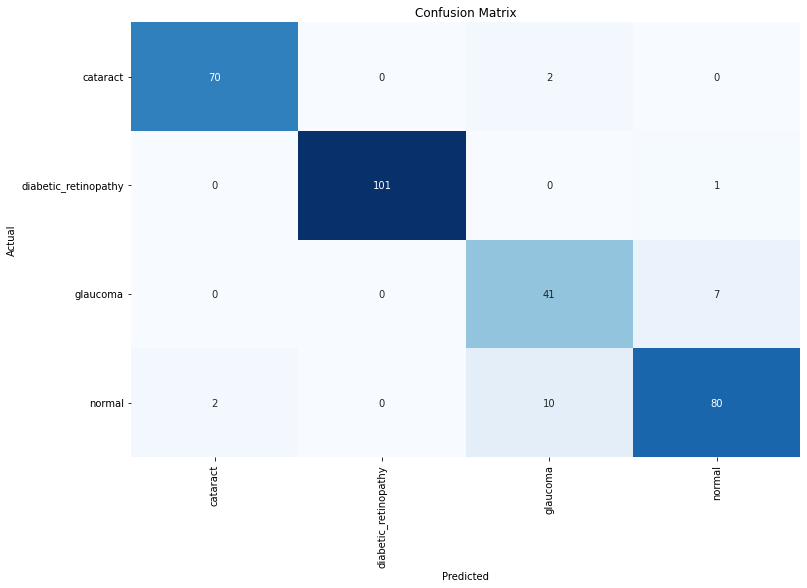

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(4)+.5, class_names, rotation=90)
plt.yticks(np.arange(4)+.5, class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Insights
#### The model acheived 93% accuracy
#### The training has run for 47 epochs and stopped by early stopping
#### The validation loss curve looks very smooth and has no fluctuations

In [ ]:
import tensorflow as tf

from keras.models import load_model

model.save('TL.hdf5')

In [ ]:
tf.keras.models.save_model(model, "TL.hdf5")

In [ ]:
!pip install streamlit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.7/238.7 KB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 KB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 12.6 MB/s eta 0:00:00
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=9ef5d63a18b504aa22a78e47b2e483768486dda6956193

In [ ]:
!killall ngrok

ngrok: no process found


In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf

st.set_option('deprecation.showfileUploaderEncoding',False)
@st.cache(allow_output_mutation=True)
def load_model():
    model = tf.keras.models.load_model('/content/TL.hdf5')
    return model
model = load_model()

st.write("""
         # Eye Disease Detection 
         """
        )

file = st.file_uploader("Please upload the image of eye",type=["jpg","png"])
#import cv2
from PIL import Image,ImageOps
import numpy as np

def import_and_predict(img,model):
    size = (224,224)
    image = ImageOps.fit(img,size,Image.ANTIALIAS)
    img = np.asarray(image)
    img_reshape = img[np.newaxis,...]
    prediction = model.predict(img_reshape)
    
    return prediction

if file is None:
    st.text("Please upload an image")
else:
    image = Image.open(file)
    st.image(image,use_column_width=True)
    predictions = import_and_predict(image,model)
    class_names= ['Cataract', 'Diabetic_retinopathy', 'Glaucoma', 'Normal']
    string = "This is image is most likely is : "+class_names[np.argmax(predictions)]
    st.success(string)

Writing app.py


In [ ]:
!ngrok authtoken 2Mv4GPuvYY8Fcbm9CiNTldOd6GI_3nchiqZqvTQ1VKSnKssDD

/bin/bash: ngrok: command not found


In [ ]:
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 KB 45.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-5.2.1-py3-none-any.whl size=19792 sha256=b76f0bcbe1f148ae1a42ac8e70dcdf15b4a0c9dd8308e38df9d50a70967b014d
  Stored in directory: /root/.cache/pip/wheels/f6/89/59/49d4249e00957e94813ac136a335d10ed2e09a856c5096f95c
Successfully built pyngrok


In [ ]:
!ngrok http 80

In [ ]:
!nohup streamlit run app.py &

In [ ]:
import streamlit
!streamlit run --server.port 80 app.py >/dev/null

In [ ]:
# from pyngrok import ngrok 
# public_url = ngrok.connect(port='8501')
# public_url

In [ ]:
# !cat /content/nohup.out

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

In [ ]:
!unzip ngrok-stable-linux-amd64.zip

In [ ]:
get_ipython().system_raw('./ngrok http 8501 &')

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

In [ ]:
!streamlit run /content/app.py

# Conclusion

#### It's very intersting how transfer learning can improve and satisfy our goals with higher accuracy, consistent and faster
#### With pretraind model, we achieved 93% with 7% improvment from our own Neural network 90%